In [1]:
import pandas as pd
import numpy as np
import os

import sklearn.metrics as metrics

from sklearn import svm

from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, recall_score, \
    accuracy_score, precision_score, r2_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

import matplotlib.pyplot as plt

import sklearn
print(sklearn.__version__)

0.23.1


In [3]:
df_sample = pd.read_csv("data/sample.csv")

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")


In [6]:
def gen_feats_dict(df_train):
    fv = df_train['Sequence'].values
    

    fv_1plex_list = []
    for i in range(len(fv)):
        for j in range(0,4):
            fv_1plex_list.append(fv[i][j:j+1])
    feats1 = list(set(fv_1plex_list))
    #print(i)
    #print(j)
    #print(len(feats1))
    
    feats_dict = {}
    
    feats_dict['1plex_pos0']=feats1
    feats_dict['1plex_pos1']=feats1
    feats_dict['1plex_pos2']=feats1
    feats_dict['1plex_pos3']=feats1
        
    return(feats_dict)


In [7]:
def gen_occ(df,feats_dict):
    
    fv = df['Sequence'].values
    
    occ = {}
    
    fv_1plex_list = []
    for i in range(len(fv)):
        for j in range(0,4):
            fv_1plex_list.append(fv[i][j:j+1])
    #1-plex
    for i in range(len(feats_dict['1plex'])):
        feat = feats_dict['1plex'][i]
        count = fv_1plex_list.count(feat)
        occ[feat] = count
        print("%s: %d"%(feat,count))
    
    return(occ)

In [8]:
def gen_X(df,feats_dict):
    n = df.shape[0]
    d = 0
    for feat_type in list(feats_dict):
        d+=len(feats_dict[feat_type])
    X = np.zeros((n,d))
    print(np.shape(X))
    
    seqs = df["Sequence"].values
    i=0
    for feat_type in list(feats_dict):
        pos = int(feat_type[-1])
        plex = int(feat_type[0])
        for j in range(len(feats_dict[feat_type])):

            for k in range(len(seqs)):
                if feats_dict[feat_type][j] == seqs[k][pos:pos+plex]:
                    X[k][i] = 1

            if i%10==0:
                print(i)
            i+=1

    return(X)
    

In [9]:
feats_dict = gen_feats_dict(df_train)


111999
3
20


In [10]:
X_train_raw = gen_X(df_train,feats_dict)
X_test_raw = gen_X(df_test,feats_dict)

(112000, 80)
0
10
20
30
40
50
60
70
(48000, 80)
0
10
20
30
40
50
60
70


In [12]:


holdout=False
feat_sel1=False
feat_sel2=False

if holdout:
    #make hold out
    X_train,X_hold,y_train,y_hold = train_test_split(
        X_train_raw,y_train,test_size=0.2,random_state=42)

    print(np.shape(X_train))
    print(np.shape(X_hold))
    print(np.sum(y_train))
    print(np.sum(y_hold))
    print("\n")
else:
    X_train = X_train_raw.copy()
    
X_test = X_test_raw.copy()
    
y_train = df_train['Active'].values
n = float(np.shape(y_train)[0])    

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

if feat_sel1:
    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
    model = SelectFromModel(lsvc, prefit=True)
    X_train = model.transform(X_train)
    X_test = model.transform(X_test)
    
if feat_sel2:
    #feature selection by conditional probability threshold
    a = np.sum(X_train,axis=0)
    b = np.sum(np.transpose(X_train)*y_train,axis=1)
    print(np.shape(a))
    print(np.shape(b))
    c = b/a
    d = np.argwhere(c>0.2).flatten()
    
    X_train = X_train[:,d]
    X_test = X_test[:,d]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
    







(112000, 80)
(112000,)
(48000, 80)
(112000, 80)
(112000,)
(48000, 80)


In [51]:

hp_x = np.array([0.56])
hp_metrics = [
           'test_accuracy',
           'test_recall',
           'test_precision'
          ]
hp_y = np.zeros((hp_x.shape[0],len(hp_metrics)))

for j in range(0,hp_x.shape[0]):

    """
    clf_init = GaussianNB()
    
    clf_init = LinearSVC(
        penalty='l1',
        C=hp_x[j],
        dual=False,
        random_state=42,tol=1e-5)
        
    clf_init = LinearSVC(
        C=hp_x[j],
        class_weight='balanced',
        random_state=42,tol=1e-5)
        
    clf_init = LinearSVC(
        C=0.56,
        class_weight={0:0.52,1:13.3*hp_x[j]},
        random_state=42,tol=1e-5)
    #tuning class weights didn't do too much
        
    HistGradientBoostingClassifier(random_state=42)
    clf_init = HistGradientBoostingClassifier(verbose=10,random_state=42)
    #too slow
    
    clf_init = BernoulliNB(class_prior=[1-hp_x[j],hp_x[j]])
    #performance not as good
    
    clf_init = LinearSVC(
        C=hp_x[j],
        random_state=42,tol=1e-5)
    """

    
    clf_init = HistGradientBoostingClassifier(
        learning_rate = hp_x[j],
        max_iter=200,
        max_leaf_nodes=127,
        min_samples_leaf=20,
        l2_regularization=32.0,
        verbose=10,
        random_state=42)
    
    clf = clf_init.fit(X_train,y_train)
    score = clf.score(X_train,y_train)

    cv_results = cross_validate(clf,X_train,y_train,cv=5,
            scoring=["roc_auc","accuracy","recall","precision"])

    print("train score= %f"%score)
    print("cv roc auc= %f"%np.mean(cv_results['test_roc_auc']))
    print("cv acc= %f"%np.mean(cv_results['test_accuracy']))
    hp_y[j][0] = np.mean(cv_results['test_accuracy'])
    
    print("cv rec= %f"%np.mean(cv_results['test_recall']))
    hp_y[j][1] = np.mean(cv_results['test_recall'])
    
    print("cv prec= %f"%np.mean(cv_results['test_precision']))
    hp_y[j][2] = np.mean(cv_results['test_precision'])

    #print(sigmoid(clf.decision_function(X_train)))
    #p_train=clf.predict(X_train)

    print("y train:")
    print("n pos %f"%np.sum(y_train))
    print("frac pos %f"%(np.sum(y_train)/n))

    print("y train pred:")
    y_train_pred=clf.predict(X_train)
    print("n pos %f"%np.sum(y_train_pred))
    print("frac pos %f"%(np.sum(y_train_pred)/n) ) 

    #p_train=clf.predict_proba(X_train)
    #print("prob sum 0 %f"%np.sum(p_train[:,0]))
    #print("prob sum 1 %f"%np.sum(p_train[:,1]))

    #print(p_train)

    #print("y test:")
    #p_test=clf.predict_proba(X_test)
    #print("prob sum 0 %f"%np.sum(p_test[:,0]))
    #print("prob sum 1 %f"%np.sum(p_test[:,1]))

    if holdout:
        #print("holdout metrics:")
        #holdout_auc = roc_auc_score(y_hold,clf.predict_proba(X_hold)[:,1])
        #print("holdout roc auc= %f"%holdout_auc)
        #holdout_aucs[i] = holdout_auc

        y_hold_pred = clf.predict(X_hold)
        holdout_acc = accuracy_score(y_hold,y_hold_pred)
        print("holdout acc= %f"%holdout_acc)
        holdout_rec = recall_score(y_hold,y_hold_pred)
        print("holdout rec= %f"%holdout_rec)
        holdout_prec = precision_score(y_hold,y_hold_pred)
        print("holdout prec= %f"%holdout_prec)

Binning 0.065 GB of training data: 0.447 s
Binning 0.007 GB of validation data: 0.008 s
Fitting gradient boosted rounds:
[1/200] 1 tree, 90 leaves, max depth = 22, train loss: 0.09865, val loss: 0.10212, in 0.090s
[2/200] 1 tree, 127 leaves, max depth = 34, train loss: 0.07511, val loss: 0.07881, in 0.115s
[3/200] 1 tree, 127 leaves, max depth = 30, train loss: 0.06237, val loss: 0.06578, in 0.090s
[4/200] 1 tree, 127 leaves, max depth = 30, train loss: 0.05293, val loss: 0.05651, in 0.103s
[5/200] 1 tree, 127 leaves, max depth = 23, train loss: 0.04882, val loss: 0.05252, in 0.087s
[6/200] 1 tree, 127 leaves, max depth = 29, train loss: 0.04393, val loss: 0.04753, in 0.088s
[7/200] 1 tree, 127 leaves, max depth = 27, train loss: 0.04022, val loss: 0.04424, in 0.087s
[8/200] 1 tree, 127 leaves, max depth = 45, train loss: 0.03698, val loss: 0.04088, in 0.112s
[9/200] 1 tree, 127 leaves, max depth = 26, train loss: 0.03494, val loss: 0.03902, in 0.089s
[10/200] 1 tree, 120 leaves, max d

[8/200] 1 tree, 127 leaves, max depth = 25, train loss: 0.03805, val loss: 0.04504, in 0.070s
[9/200] 1 tree, 127 leaves, max depth = 31, train loss: 0.03561, val loss: 0.04258, in 0.072s
[10/200] 1 tree, 127 leaves, max depth = 24, train loss: 0.03371, val loss: 0.04079, in 0.098s
[11/200] 1 tree, 127 leaves, max depth = 29, train loss: 0.03260, val loss: 0.04023, in 0.070s
[12/200] 1 tree, 127 leaves, max depth = 26, train loss: 0.03119, val loss: 0.03893, in 0.071s
[13/200] 1 tree, 127 leaves, max depth = 31, train loss: 0.02989, val loss: 0.03776, in 0.075s
[14/200] 1 tree, 127 leaves, max depth = 23, train loss: 0.02902, val loss: 0.03731, in 0.092s
[15/200] 1 tree, 127 leaves, max depth = 29, train loss: 0.02803, val loss: 0.03660, in 0.067s
[16/200] 1 tree, 127 leaves, max depth = 43, train loss: 0.02710, val loss: 0.03555, in 0.073s
[17/200] 1 tree, 122 leaves, max depth = 22, train loss: 0.02612, val loss: 0.03475, in 0.074s
[18/200] 1 tree, 127 leaves, max depth = 28, train l

[95/200] 1 tree, 127 leaves, max depth = 38, train loss: 0.00999, val loss: 0.02497, in 0.094s
[96/200] 1 tree, 127 leaves, max depth = 28, train loss: 0.00991, val loss: 0.02492, in 0.071s
[97/200] 1 tree, 127 leaves, max depth = 28, train loss: 0.00984, val loss: 0.02491, in 0.067s
[98/200] 1 tree, 127 leaves, max depth = 28, train loss: 0.00976, val loss: 0.02483, in 0.069s
[99/200] 1 tree, 127 leaves, max depth = 29, train loss: 0.00969, val loss: 0.02476, in 0.095s
[100/200] 1 tree, 127 leaves, max depth = 31, train loss: 0.00961, val loss: 0.02477, in 0.067s
[101/200] 1 tree, 127 leaves, max depth = 25, train loss: 0.00954, val loss: 0.02476, in 0.070s
[102/200] 1 tree, 127 leaves, max depth = 30, train loss: 0.00947, val loss: 0.02468, in 0.070s
[103/200] 1 tree, 127 leaves, max depth = 29, train loss: 0.00940, val loss: 0.02458, in 0.099s
[104/200] 1 tree, 127 leaves, max depth = 29, train loss: 0.00934, val loss: 0.02467, in 0.066s
[105/200] 1 tree, 127 leaves, max depth = 29,

[86/200] 1 tree, 127 leaves, max depth = 29, train loss: 0.01029, val loss: 0.02429, in 0.092s
[87/200] 1 tree, 127 leaves, max depth = 48, train loss: 0.01020, val loss: 0.02421, in 0.118s
[88/200] 1 tree, 127 leaves, max depth = 28, train loss: 0.01012, val loss: 0.02411, in 0.076s
[89/200] 1 tree, 127 leaves, max depth = 29, train loss: 0.01005, val loss: 0.02413, in 0.114s
[90/200] 1 tree, 127 leaves, max depth = 28, train loss: 0.00997, val loss: 0.02405, in 0.239s
[91/200] 1 tree, 127 leaves, max depth = 30, train loss: 0.00989, val loss: 0.02406, in 0.188s
[92/200] 1 tree, 127 leaves, max depth = 28, train loss: 0.00981, val loss: 0.02403, in 0.177s
[93/200] 1 tree, 127 leaves, max depth = 32, train loss: 0.00974, val loss: 0.02404, in 0.237s
[94/200] 1 tree, 127 leaves, max depth = 26, train loss: 0.00966, val loss: 0.02404, in 0.221s
[95/200] 1 tree, 127 leaves, max depth = 44, train loss: 0.00957, val loss: 0.02399, in 0.189s
[96/200] 1 tree, 127 leaves, max depth = 27, train

[13/200] 1 tree, 122 leaves, max depth = 25, train loss: 0.03014, val loss: 0.03666, in 0.103s
[14/200] 1 tree, 127 leaves, max depth = 26, train loss: 0.02909, val loss: 0.03568, in 0.135s
[15/200] 1 tree, 127 leaves, max depth = 29, train loss: 0.02797, val loss: 0.03464, in 0.122s
[16/200] 1 tree, 127 leaves, max depth = 28, train loss: 0.02718, val loss: 0.03403, in 0.075s
[17/200] 1 tree, 127 leaves, max depth = 32, train loss: 0.02645, val loss: 0.03340, in 0.083s
[18/200] 1 tree, 127 leaves, max depth = 29, train loss: 0.02567, val loss: 0.03286, in 0.078s
[19/200] 1 tree, 127 leaves, max depth = 34, train loss: 0.02494, val loss: 0.03194, in 0.104s
[20/200] 1 tree, 127 leaves, max depth = 29, train loss: 0.02434, val loss: 0.03142, in 0.077s
[21/200] 1 tree, 127 leaves, max depth = 31, train loss: 0.02372, val loss: 0.03112, in 0.082s
[22/200] 1 tree, 127 leaves, max depth = 30, train loss: 0.02319, val loss: 0.03052, in 0.079s
[23/200] 1 tree, 127 leaves, max depth = 29, train

[100/200] 1 tree, 127 leaves, max depth = 26, train loss: 0.00945, val loss: 0.02308, in 0.137s
[101/200] 1 tree, 127 leaves, max depth = 28, train loss: 0.00938, val loss: 0.02311, in 0.088s
[102/200] 1 tree, 127 leaves, max depth = 26, train loss: 0.00931, val loss: 0.02305, in 0.102s
[103/200] 1 tree, 127 leaves, max depth = 32, train loss: 0.00925, val loss: 0.02309, in 0.096s
[104/200] 1 tree, 127 leaves, max depth = 29, train loss: 0.00918, val loss: 0.02304, in 0.099s
[105/200] 1 tree, 127 leaves, max depth = 29, train loss: 0.00911, val loss: 0.02307, in 0.083s
[106/200] 1 tree, 127 leaves, max depth = 26, train loss: 0.00905, val loss: 0.02302, in 0.184s
[107/200] 1 tree, 127 leaves, max depth = 28, train loss: 0.00899, val loss: 0.02296, in 0.147s
[108/200] 1 tree, 127 leaves, max depth = 30, train loss: 0.00892, val loss: 0.02298, in 0.129s
[109/200] 1 tree, 127 leaves, max depth = 29, train loss: 0.00886, val loss: 0.02294, in 0.169s
[110/200] 1 tree, 127 leaves, max depth 

[32/200] 1 tree, 127 leaves, max depth = 25, train loss: 0.01918, val loss: 0.02776, in 0.097s
[33/200] 1 tree, 127 leaves, max depth = 31, train loss: 0.01891, val loss: 0.02745, in 0.122s
[34/200] 1 tree, 127 leaves, max depth = 27, train loss: 0.01863, val loss: 0.02733, in 0.167s
[35/200] 1 tree, 127 leaves, max depth = 25, train loss: 0.01838, val loss: 0.02742, in 0.109s
[36/200] 1 tree, 127 leaves, max depth = 40, train loss: 0.01805, val loss: 0.02725, in 0.166s
[37/200] 1 tree, 127 leaves, max depth = 26, train loss: 0.01780, val loss: 0.02713, in 0.190s
[38/200] 1 tree, 127 leaves, max depth = 25, train loss: 0.01748, val loss: 0.02701, in 0.140s
[39/200] 1 tree, 127 leaves, max depth = 27, train loss: 0.01726, val loss: 0.02694, in 0.178s
[40/200] 1 tree, 127 leaves, max depth = 33, train loss: 0.01702, val loss: 0.02675, in 0.165s
[41/200] 1 tree, 127 leaves, max depth = 26, train loss: 0.01679, val loss: 0.02642, in 0.111s
[42/200] 1 tree, 127 leaves, max depth = 33, train

[24/200] 1 tree, 127 leaves, max depth = 28, train loss: 0.02237, val loss: 0.02941, in 0.126s
[25/200] 1 tree, 127 leaves, max depth = 29, train loss: 0.02181, val loss: 0.02894, in 0.093s
[26/200] 1 tree, 127 leaves, max depth = 28, train loss: 0.02140, val loss: 0.02877, in 0.097s
[27/200] 1 tree, 127 leaves, max depth = 30, train loss: 0.02104, val loss: 0.02833, in 0.094s
[28/200] 1 tree, 127 leaves, max depth = 29, train loss: 0.02059, val loss: 0.02792, in 0.121s
[29/200] 1 tree, 127 leaves, max depth = 29, train loss: 0.02019, val loss: 0.02752, in 0.100s
[30/200] 1 tree, 127 leaves, max depth = 27, train loss: 0.01986, val loss: 0.02733, in 0.098s
[31/200] 1 tree, 127 leaves, max depth = 30, train loss: 0.01954, val loss: 0.02729, in 0.100s
[32/200] 1 tree, 127 leaves, max depth = 24, train loss: 0.01922, val loss: 0.02693, in 0.127s
[33/200] 1 tree, 127 leaves, max depth = 25, train loss: 0.01884, val loss: 0.02659, in 0.097s
[34/200] 1 tree, 127 leaves, max depth = 26, train

[111/200] 1 tree, 127 leaves, max depth = 27, train loss: 0.00861, val loss: 0.02105, in 0.102s
[112/200] 1 tree, 127 leaves, max depth = 23, train loss: 0.00856, val loss: 0.02103, in 0.090s
[113/200] 1 tree, 127 leaves, max depth = 26, train loss: 0.00849, val loss: 0.02102, in 0.125s
[114/200] 1 tree, 127 leaves, max depth = 25, train loss: 0.00843, val loss: 0.02100, in 0.100s
[115/200] 1 tree, 127 leaves, max depth = 29, train loss: 0.00837, val loss: 0.02092, in 0.095s
[116/200] 1 tree, 127 leaves, max depth = 24, train loss: 0.00831, val loss: 0.02095, in 0.102s
[117/200] 1 tree, 127 leaves, max depth = 27, train loss: 0.00826, val loss: 0.02092, in 0.118s
[118/200] 1 tree, 127 leaves, max depth = 31, train loss: 0.00821, val loss: 0.02088, in 0.073s
[119/200] 1 tree, 127 leaves, max depth = 31, train loss: 0.00816, val loss: 0.02084, in 0.156s
[120/200] 1 tree, 127 leaves, max depth = 28, train loss: 0.00810, val loss: 0.02084, in 0.138s
[121/200] 1 tree, 127 leaves, max depth 

[197/200] 1 tree, 127 leaves, max depth = 29, train loss: 0.00528, val loss: 0.02006, in 0.078s
[198/200] 1 tree, 127 leaves, max depth = 23, train loss: 0.00526, val loss: 0.02007, in 0.104s
[199/200] 1 tree, 127 leaves, max depth = 30, train loss: 0.00523, val loss: 0.02006, in 0.078s
[200/200] 1 tree, 127 leaves, max depth = 31, train loss: 0.00520, val loss: 0.02007, in 0.076s
Fit 200 trees in 21.833 s, (25362 total leaves)
Time spent computing histograms: 11.824s
Time spent finding best splits:  2.355s
Time spent applying splits:      4.346s
Time spent predicting:           0.065s
train score= 0.998875
cv roc auc= 0.997894
cv acc= 0.992223
cv rec= 0.863520
cv prec= 0.924794
y train:
n pos 4213.000000
frac pos 0.037616
y train pred:
n pos 4155.000000
frac pos 0.037098


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

In [ ]:
p_train=clf.predict_proba(X_train)
print("prob sum 0 %f"%np.sum(p_train[:,0]))
print("prob sum 1 %f"%np.sum(p_train[:,1]))

In [ ]:
print(n/(2*np.bincount(y_train)))


In [53]:


print("y test pred:")
y_test_pred=clf.predict(X_test)
print("n pos %f"%np.sum(y_test_pred))
print("frac pos %f"%(np.sum(y_test_pred)/n) )

y test pred:
n pos 1700.000000
frac pos 0.015179


In [54]:
y_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [55]:
result_str = ""
for i in range(len(y_test_pred)):
    result_str+=str(y_test_pred[i])
    result_str+="\n"

submission = open("sub.csv","w")
submission.write(result_str)
submission.close()

In [56]:
#HIST GBDT l2, stepsize experiment, 200 trees/iter

print(hp_x)
print(hp_y)

[0.56]
[[0.99222321 0.86352045 0.92479429]]


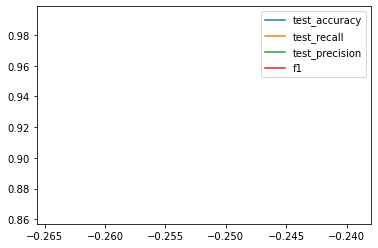

In [57]:
f1 = plt.figure()
ax1 = f1.add_subplot(111)
for k in range(0,len(hp_metrics)):
    ax1.plot(np.log10(hp_x),hp_y[:,k],label=hp_metrics[k])
    
f1 = 2*hp_y[:,1]*hp_y[:,2]/(hp_y[:,1]+hp_y[:,2])
ax1.plot(np.log10(hp_x),f1,label="f1")
    
ax1.legend()
plt.show()

In [58]:
f1

array([0.89310765])

In [ ]:


clf_init = HistGradientBoostingClassifier(random_state=42)
clf = fit_model1(X_train,y_train,clf_init,sw_dict={0:w0,1:w1})
score = clf.score(X_train,y_train)

cv_results = cross_validate(clf,X_train,y_train,cv=5,
        scoring=["roc_auc","accuracy","recall","precision"])

print("train score= %f"%score)
print("cv roc auc= %f"%np.mean(cv_results['test_roc_auc']))
print("cv acc= %f"%np.mean(cv_results['test_accuracy']))
print("cv rec= %f"%np.mean(cv_results['test_recall']))
print("cv prec= %f"%np.mean(cv_results['test_precision']))

#print(sigmoid(clf.decision_function(X_train)))
#p_train=clf.predict(X_train)

print("y train:")
print("n pos %f"%np.sum(y_train))
print("frac pos %f"%(np.sum(y_train)/n))

print("y train pred:")
y_train_pred=clf.predict(X_train)
print("n pos %f"%np.sum(y_train_pred))
print("frac pos %f"%(np.sum(y_train_pred)/n) ) 

p_train=clf.predict_proba(X_train)
print("prob sum 0 %f"%np.sum(p_train[:,0]))
print("prob sum 1 %f"%np.sum(p_train[:,1]))

#print(p_train)

print("y test:")
p_test=clf.predict_proba(X_test)
print("prob sum 0 %f"%np.sum(p_test[:,0]))
print("prob sum 1 %f"%np.sum(p_test[:,1]))

if holdout:
    print("holdout metrics:")
    holdout_auc = roc_auc_score(y_hold,clf.predict_proba(X_hold)[:,1])
    print("holdout roc auc= %f"%holdout_auc)
    holdout_aucs[i] = holdout_auc

    y_hold_pred = clf.predict(X_hold)
    holdout_acc = accuracy_score(y_hold,y_hold_pred)
    print("holdout acc= %f"%holdout_acc)
    holdout_rec = recall_score(y_hold,y_hold_pred)
    print("holdout rec= %f"%holdout_rec)
    holdout_prec = precision_score(y_hold,y_hold_pred)
    print("holdout prec= %f"%holdout_prec)

In [ ]:
active = df_train[df_train['Active']==1]
asv = active['Sequence'].values
asv_str = ''.join(list(asv))
asv_1plex = asv_str

chars = ''.join(set(asv_str))
feats1 = chars

occ = {}

#1-plex
for i in range(len(chars)):
    count = asv_str.count(chars[i])
    occ[chars[i]] = count
    print("%s: %d"%(chars[i],count))
    



In [ ]:
asv_2plex_list = []
for i in range(len(asv)):
    for j in range(0,3):
        asv_2plex_list.append(asv[i][j:j+2])

feats2 = list(set(asv_2plex_list))
print(len(feats2))

occ = {}
#2-plex
for i in range(len(feats2)):
    count = asv_2plex_list.count(feats2[i])
    occ[feats2[i]] = count
    print("%s: %d"%(feats2[i],count))

In [ ]:
asv_3plex_list = []
for i in range(len(asv)):
    for j in range(0,2):
        asv_3plex_list.append(asv[i][j:j+3])

feats3 = list(set(asv_3plex_list))
print(len(feats3))

occ = {}
#3-plex
for i in range(len(feats3)):
    count = asv_3plex_list.count(feats3[i])
    occ[feats3[i]] = count
    print("%s: %d"%(feats3[i],count))

In [ ]:
len(asv)

In [ ]:
asv_2plex_list

In [ ]:
feats2 = list(set(asv_2plex_list))

In [ ]:
len(feats2)

In [ ]:
feats2

In [ ]:
active = df_train[df_train['Active']!=2]
asv = active['Sequence'].values
asv_str = ''.join(list(asv))
chars = ''.join(set(asv_str))
occ = {}
for i in range(len(chars)):
    count = asv_str.count(chars[i])
    occ[chars[i]] = count
    print("%s: %d"%(chars[i],count))

In [ ]:
useqs

In [ ]:
def standardize(X_train,X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return(X_train,X_test)
    

def impute(X_train,X_test):
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp_mean.fit(X_train)
    
    X_train = imp_mean.transform(X_train)
    X_test = imp_mean.transform(X_test)

    #print(X_train_imp)
    return(X_train,X_test)

def forest_fi(X_train,y_train,X_test):

    forest = ExtraTreesClassifier(n_estimators=20,
                                  random_state=0)

    forest.fit(X_train,y_train)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    for f in range(X_train.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    X_train = X_train[:,indices[:50]]
    X_test = X_test[:,indices[:50]]
    return(X_train,X_test)


def nystroem(X_train,X_test):
    gamma=1.0
    n_components=100
    print("nystroem gamma=%f"%(gamma))
    print("nystroem q=%d"%(n_components))
    feature_map_nystroem = Nystroem(gamma=gamma,
                                    random_state=42,
                                    n_components=n_components)
    feature_map_nystroem.fit(X_train)
    Q_train = feature_map_nystroem.transform(X_train)
    sqrt_k_inv_train = np.linalg.inv(feature_map_nystroem.normalization_)
    B_train = np.dot(Q_train,sqrt_k_inv_train)
    K_train = np.dot(B_train,np.transpose(B_train))

    Q_test = feature_map_nystroem.transform(X_test)
    sqrt_k_inv_test = np.linalg.inv(feature_map_nystroem.normalization_)
    B_test = np.dot(Q_test,sqrt_k_inv_test)
    K_test = np.dot(B_test,np.transpose(B_train))
    return(K_train,K_test)


In [ ]:
def sigmoid(x):
    return(1/(1+np.exp(-x)))

def fit_model1_1(X_train,y_train):
    print(np.shape(y_train))
    print(np.sum(y_train))
    clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, 
                                     max_depth=3, random_state=42).fit(X_train,y_train)
    #clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
    #                                 max_depth=5, random_state=42).fit(X_train_imp,y_train)

    return(clf)

def fit_model1_2(X_train,y_train):
    print(np.shape(y_train))
    print(np.sum(y_train))
    
    clf = svm.SVC(C=10,
                  class_weight="balanced",
                  decision_function_shape='ovo').fit(X_train,y_train)
    return(clf)

def fit_model1(X_train,y_train,clf_init,sw_dict={}):
    n = np.shape(y_train)[0]
    w0 = n/(n-np.sum(y_train))
    w1 = n/np.sum(y_train)
    
    sample_weight = np.zeros(len(y_train))
    if not(sw_dict):
        print("using default sample weights")
        sample_weight[y_train == 0] = w0
        sample_weight[y_train == 1] = w1
    else:
        print("using custom sample weights")
        sample_weight[y_train == 0] = sw_dict[0]
        sample_weight[y_train == 1] = sw_dict[1]
    
    print("Shape and sum of y_train")
    print(np.shape(y_train))
    print(np.sum(y_train))
    clf = clf_init
    #clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, 
    #                                 max_depth=3, random_state=42)
    clf.fit(X_train,y_train,sample_weight=sample_weight)
    #clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
    #                                 max_depth=5, random_state=42).fit(X_train_imp,y_train)

    return(clf)

def fit_model2_1(X_train,y_train,hps):
    C = hps["C"]
    #class_weight={1:16.5}
    class_weight={1:hps["w1"]}
    print("Shape and sum of y_train")
    print(np.shape(y_train))
    print(np.sum(y_train))
    
    clf = svm.SVC(C=hps["C"],
                  kernel="rbf",
                  gamma=hps["gamma"],
                  class_weight=class_weight,
                  decision_function_shape='ovo',
                  verbose=True).fit(X_train,y_train)
    print("C: %f"%hps["C"])
    print("gamma: %f"%hps["gamma"])
    print("Computed class weight: %s"%(str(clf.class_weight_)))
    return(clf)

def fit_model2_2(K_train,y_train):
    C = 1.0
    class_weight={1:17.5}
    print("Shape and sum of y_train")
    print(np.shape(y_train))
    print(np.sum(y_train))
    
    clf = svm.SVC(C=C,
                  kernel="precomputed",
                  class_weight="balanced",
                  decision_function_shape='ovo',
                  verbose=True).fit(K_train,y_train)
    print("C: %f"%C)
    print("Computed class weight: %s"%(str(clf.class_weight_)))
    return(clf)

def fit_model2(X_train,y_train,clf_init,sw_dict={}):
    n = np.shape(y_train)[0]
    w0 = n/(n-np.sum(y_train))
    w1 = n/np.sum(y_train)
    
    sample_weight = np.zeros(len(y_train))
    if not(sw_dict):
        print("using default sample weights")
        sample_weight[y_train == 0] = w0
        sample_weight[y_train == 1] = w1
    else:
        print("using custom sample weights")
        sample_weight[y_train == 0] = sw_dict[0]
        sample_weight[y_train == 1] = sw_dict[1]
    
    print("Shape and sum of y_train")
    print(np.shape(y_train))
    print(np.sum(y_train))
    clf = clf_init
    clf.fit(X_train,y_train,sample_weight=sample_weight)
    return(clf)

def fit_model3(X_train,y_train):
    #print(np.shape(y_train))
    #print(np.sum(y_train))
    reg = HistGradientBoostingRegressor(random_state=42).fit(X_train,y_train)
    #reg = GradientBoostingRegressor(random_state=42).fit(X_train,y_train)
    return(reg)

In [ ]:
test_pids = pd.unique(df_test_feats['pid'])

df_test_labels = pd.DataFrame(columns=df_labels_cols)
df_test_labels['pid'] = test_pids

In [ ]:
X_train1_raw = feats_2_X1(df_train_feats,active_feats)
X_test1_raw = feats_2_X1(df_test_feats,active_feats)


In [ ]:
print(np.shape(X_train1_raw))
print(np.shape(X_test1_raw))
X_train_imp,X_test = impute(X_train1_raw,X_test1_raw)
print(np.shape(X_train_imp))
print(np.shape(X_test))

holdout_aucs = np.zeros(len(subtask1_labels))

for i in range(0,len(subtask1_labels)):
#for i in range(0,1):
    print("i=%d"%i)
    y_train=df_train_labels[subtask1_labels[i]].values
    n = float(np.shape(y_train)[0])

    if holdout:
        #make hold out
        X_train,X_hold,y_train,y_hold = train_test_split(
            X_train_imp,y_train,test_size=0.2,random_state=42)

        print(np.shape(X_train))
        print(np.shape(X_hold))
        print(np.sum(y_train))
        print(np.sum(y_hold))
        print("\n")
    else:
        X_train = X_train_imp

    #sample weight
    use_custom_sw = True
    if use_custom_sw:
        #sample weight
        n = float(np.shape(y_train)[0])
        w1_boost = 0.17

        w0 = n/(n-np.sum(y_train))
        w1 = (n/np.sum(y_train))*w1_boost
        geo_mean = np.sqrt(w0*w1)
        w0 /= geo_mean
        w1 /= geo_mean
    else:
        w0=1.0
        w1=1.0
    
    clf_init = HistGradientBoostingClassifier(random_state=42)
    clf = fit_model1(X_train,y_train,clf_init,sw_dict={0:w0,1:w1})
    score = clf.score(X_train,y_train)
    
    cv_results = cross_validate(clf,X_train,y_train,cv=5,
            scoring=["roc_auc","accuracy","recall","precision"])
    
    print("train score= %f"%score)
    print("cv roc auc= %f"%np.mean(cv_results['test_roc_auc']))
    print("cv acc= %f"%np.mean(cv_results['test_accuracy']))
    print("cv rec= %f"%np.mean(cv_results['test_recall']))
    print("cv prec= %f"%np.mean(cv_results['test_precision']))
    
    #print(sigmoid(clf.decision_function(X_train)))
    #p_train=clf.predict(X_train)
    
    print("y train:")
    print("n pos %f"%np.sum(y_train))
    print("frac pos %f"%(np.sum(y_train)/n))
    
    print("y train pred:")
    y_train_pred=clf.predict(X_train)
    print("n pos %f"%np.sum(y_train_pred))
    print("frac pos %f"%(np.sum(y_train_pred)/n) ) 
    
    p_train=clf.predict_proba(X_train)
    print("prob sum 0 %f"%np.sum(p_train[:,0]))
    print("prob sum 1 %f"%np.sum(p_train[:,1]))
    
    #print(p_train)
    
    print("y test:")
    p_test=clf.predict_proba(X_test)
    print("prob sum 0 %f"%np.sum(p_test[:,0]))
    print("prob sum 1 %f"%np.sum(p_test[:,1]))
    
    if holdout:
        print("holdout metrics:")
        holdout_auc = roc_auc_score(y_hold,clf.predict_proba(X_hold)[:,1])
        print("holdout roc auc= %f"%holdout_auc)
        holdout_aucs[i] = holdout_auc

        y_hold_pred = clf.predict(X_hold)
        holdout_acc = accuracy_score(y_hold,y_hold_pred)
        print("holdout acc= %f"%holdout_acc)
        holdout_rec = recall_score(y_hold,y_hold_pred)
        print("holdout rec= %f"%holdout_rec)
        holdout_prec = precision_score(y_hold,y_hold_pred)
        print("holdout prec= %f"%holdout_prec)
    
    print("\n\n")
    
    #y_test[:,1+i] = p_test[:,1]
    
    df_test_labels[subtask1_labels[i]] = p_test[:,1]
    
print("Hold out aucs and mean")
print(holdout_aucs)
print(np.mean(holdout_aucs))

In [ ]:
X_train2_raw = feats_2_X2(df_train_feats,active_feats)
X_test2_raw = feats_2_X2(df_test_feats,active_feats)




In [ ]:
print(np.shape(X_train2_raw))
print(np.shape(X_test2_raw))

X_train_imp,X_test = impute(X_train2_raw,X_test2_raw)
print(np.shape(X_train))
print(np.shape(X_test))

#X_train,X_test = standardize(X_train,X_test)
#print(np.shape(X_train))
#print(np.shape(X_test))


#X_train,X_test = nystroem(X_train,X_test)
#print(np.shape(X_train))
#print(np.shape(X_test))

hp_x = np.array([0.05])
hp_metrics = ['hold_roc_auc',
           'hold_accuracy',
           'hold_recall',
           'hold_precision'
          ]
hp_y = np.zeros((hp_x.shape[0],len(hp_metrics)))

for j in range(0,hp_x.shape[0]):
    for i in range(0,len(subtask2_labels)):
    #for i in range(0,1):
        print("i=%d"%i)
        y_train=df_train_labels[subtask2_labels[i]].values
        n = float(np.shape(y_train)[0])

        if holdout:
            #make hold out
            X_train,X_hold,y_train,y_hold = train_test_split(
                X_train_imp,y_train,test_size=0.2,random_state=42)

            print(np.shape(X_train))
            print(np.shape(X_hold))
            print(np.sum(y_train))
            print(np.sum(y_hold))
            print("\n")
        else:
            X_train = X_train_imp

        #sample weight
        use_custom_sw = True
        if use_custom_sw:
            #sample weight
            n = float(np.shape(y_train)[0])
            w1_boost = 0.17

            w0 = n/(n-np.sum(y_train))
            w1 = (n/np.sum(y_train))*w1_boost
            geo_mean = np.sqrt(w0*w1)
            w0 /= geo_mean
            w1 /= geo_mean
        else:
            w0=1.0
            w1=1.0
            
        print("class weights: %f,%f"%(w0,w1))

        clf_init = HistGradientBoostingClassifier(
            learning_rate=hp_x[j],random_state=42)
        clf = fit_model2(X_train,y_train,clf_init,sw_dict={0:w0,1:w1})
        score = clf.score(X_train,y_train)

        cv_results = cross_validate(clf,X_train,y_train,cv=5,
                scoring=["roc_auc","accuracy","recall","precision"])

        print("train score= %f"%score)
        print("cv roc auc= %f"%np.mean(cv_results['test_roc_auc']))
        print("cv acc= %f"%np.mean(cv_results['test_accuracy']))
        print("cv rec= %f"%np.mean(cv_results['test_recall']))
        print("cv prec= %f"%np.mean(cv_results['test_precision']))

        #print(sigmoid(clf.decision_function(X_train)))
        #p_train=clf.predict(X_train)

        print("y train:")
        print("n pos %f"%np.sum(y_train))
        print("frac pos %f"%(np.sum(y_train)/n))

        print("y train pred:")
        y_train_pred=clf.predict(X_train)
        print("n pos %f"%np.sum(y_train_pred))
        print("frac pos %f"%(np.sum(y_train_pred)/n) ) 

        p_train=clf.predict_proba(X_train)
        print("prob sum 0 %f"%np.sum(p_train[:,0]))
        print("prob sum 1 %f"%np.sum(p_train[:,1]))

        #print(p_train)

        print("y test:")
        p_test=clf.predict_proba(X_test)
        print("prob sum 0 %f"%np.sum(p_test[:,0]))
        print("prob sum 1 %f"%np.sum(p_test[:,1]))

        if holdout:

            print("holdout metrics:")
            holdout_auc = roc_auc_score(y_hold,clf.predict_proba(X_hold)[:,1])
            print("holdout roc auc= %f"%holdout_auc)
            hp_y[j][0] = holdout_auc

            y_hold_pred = clf.predict(X_hold)
            holdout_acc = accuracy_score(y_hold,y_hold_pred)
            print("holdout acc= %f"%holdout_acc)
            hp_y[j][1] = holdout_acc

            holdout_rec = recall_score(y_hold,y_hold_pred)
            print("holdout rec= %f"%holdout_rec)
            hp_y[j][2] = holdout_rec

            holdout_prec = precision_score(y_hold,y_hold_pred)
            print("holdout prec= %f"%holdout_prec)
            hp_y[j][3] = holdout_prec


        print("\n\n")

        #y_test[:,1+i] = p_test[:,1]

        df_test_labels[subtask2_labels[i]] = p_test[:,1]

In [ ]:
f1 = plt.figure()
ax1 = f1.add_subplot(111)
for k in range(0,len(hp_metrics)):
    ax1.plot(np.log10(hp_x),hp_y[:,k],label=hp_metrics[k])
ax1.legend()
plt.show()

In [ ]:
df_test_labels

In [ ]:
X_train3_raw = feats_2_X3(df_train_feats,subtask3_feats)
X_test3_raw = feats_2_X3(df_test_feats,subtask3_feats)


In [ ]:
print(np.shape(X_train3_raw))
print(np.shape(X_test3_raw))

X_train_imp,X_test = impute(X_train3_raw,X_test3_raw)
print(np.shape(X_train_imp))
print(np.shape(X_test))

#X_train,X_test = standardize(X_train,X_test)
#print(np.shape(X_train))
#print(np.shape(X_test))



holdout_r2s = np.zeros(len(subtask3_labels))

for i in range(0,len(subtask3_labels)):
#for i in range(0,1):
    print("i=%d"%i)
    y_train=df_train_labels[subtask3_labels[i]].values
    
    if holdout:
        #make hold out
        X_train,X_hold,y_train,y_hold = train_test_split(
            X_train_imp,y_train,test_size=0.2,random_state=42)

        print(np.shape(X_train))
        print(np.shape(X_hold))
        print(np.sum(y_train))
        print(np.sum(y_hold))
        print("\n")
    else:
        X_train = X_train_imp

    reg = fit_model3(X_train,y_train)
    
    score = reg.score(X_train,y_train)
    cv_results = cross_validate(reg,X_train,y_train,cv=5,
            scoring=["r2"])
    
    print("train score= %f"%score)
    print("cv r2= %f"%np.mean(cv_results['test_r2']))
    
    y_train_pred=reg.predict(X_train)
    print(np.mean(y_train_pred))
    print(np.std(y_train_pred))
    
    y_test=reg.predict(X_test)
    print(np.mean(y_test))
    print(np.std(y_test))
    
    if holdout:
        print("holdout metrics:")
        holdout_r2 = r2_score(y_hold,reg.predict(X_hold))
        print("holdout roc auc= %f"%holdout_r2)
        holdout_r2s[i] = holdout_r2
        #hp_y[j][0] = holdout_auc
    
    df_test_labels[subtask3_labels[i]] = y_test

In [ ]:
df_test_labels

In [ ]:
df_test_labels.to_csv('prediction_1904_8.zip', index=False, float_format='%.3f', compression='zip')